In [2]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library
from keras.models import Sequential
from keras.layers import  Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from keras.applications import VGG16, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
#from itertools import chain

#  Distributed Computing
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'
                        )
print('Data Augmentation 2 was created')

Data Augmentation 1 was created
Data Augmentation 2 was created


In [6]:
data_generator_3 = ImageDataGenerator(rescale=1./255)

train_generator1 = data_generator_1.flow_from_directory(
    directory=r"dataset_main\train",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print('Data Augmentation 1 was used to generate the train data set\n')

test_generator = data_generator_3.flow_from_directory(
    directory=r"dataset_main\test",
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

Found 2635 images belonging to 2 classes.
Data Augmentation 1 was used to generate the train data set

Found 405 images belonging to 2 classes.


In [7]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'emergency': 0, 'random': 1}
Class labels: ['emergency', 'random']


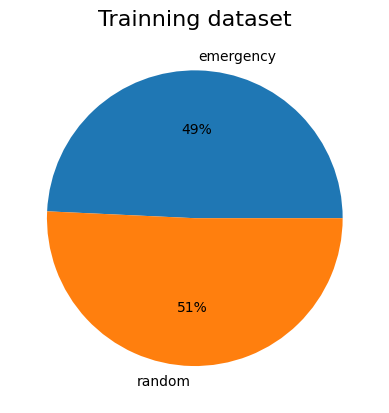

In [8]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [9]:
# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator1.classes))
print("Number of bacterial pneumonia images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of normal images:", len([label for label in train_generator1.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in train_generator1.classes if label == 2]))
print()

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of bacterial pneumonia images:", len([label for label in test_generator.classes if label == 0]))
print("Number of normal images:", len([label for label in test_generator.classes if label == 1]))
print("Number of viral pneumonia images:", len([label for label in test_generator.classes if label == 2]))
print()

Dataset Characteristics of Train Data Set:
Number of images: 2635
Number of bacterial pneumonia images: 1298
Number of normal images: 1337
Number of viral pneumonia images: 0

Dataset Characteristics of Test Data Set:
Number of images: 405
Number of bacterial pneumonia images: 205
Number of normal images: 200
Number of viral pneumonia images: 0



In [10]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights


{0: 1.0150231124807396, 1: 0.9854151084517576}

Train image data from Data Augmentation 1


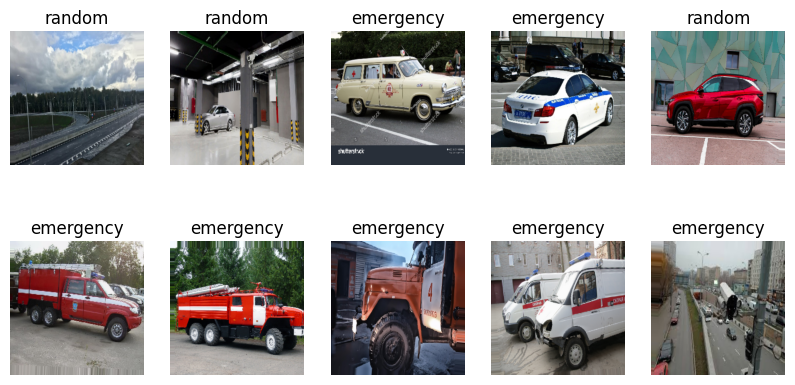

In [11]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)
# print(len(label))

plt.figure(figsize=[10, 5])
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])
plt.show()

In [12]:
# Define the epochs for training
EPOCHS = 15

# Define the number of GPUs to use
num_gpus = 2

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

train_data = train_generator1

In [16]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained VGG16 model without the top classification layer
    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_VGG16.layers:
        layer.trainable = False

    # Create a new model and add the VGG16 base model
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)

    # Add a fully connected layer and output layer for classification
    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu'))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu'))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(2, activation='softmax'))


    # Model summary
    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()

    # Compile the model
    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (VGG16):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 350s 6s/step - accuracy: 0.6540 - loss: 0.6478 - val_accuracy: 0.7704 - val_loss: 0.4636
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 341s 6s/step - accuracy: 0.8069 - loss: 0.4223 - val_accuracy: 0.7630 - val_loss: 0.4677
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.8487 - loss: 0.3501 - val_accuracy: 0.8420 - val_loss: 0.4057
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 323s 6s/step - accuracy: 0.8593 - loss: 0.3289 - val_accuracy: 0.8395 - val_loss: 0.3967
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.8753 - loss: 0.2863 - val_accuracy: 0.8519 - val_loss: 0.3563
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.9032 - loss: 0.2531 - val_accuracy: 0.8519 - val_loss: 0.3428
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.9053 - loss: 0.2421 - val_accuracy: 0.8642 - val_loss: 0.3333
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.9106 - loss: 0.2220 - val_accuracy: 0.7975 - 

In [17]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained MobileNetV2 model without the top classification layer
    base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_MobileNet.layers:
        layer.trainable = False

    # Create a new model and add the MobileNetV2 base model
    model_MobileNet = Sequential()
    model_MobileNet.add(base_model_MobileNet)

    # Add a global average pooling layer and output layer for classification
    model_MobileNet.add(GlobalAveragePooling2D())
    model_MobileNet.add(Dense(128, activation='relu'))
    model_MobileNet.add(Dropout(0.4))
    model_MobileNet.add(Dense(64, activation='relu'))
    model_MobileNet.add(Dropout(0.2))
    model_MobileNet.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (MobileNetV2):")
    model_MobileNet.summary()
    print()

    # Compile the model
    model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_MobileNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


C:\Users\HP\AppData\Local\Temp\ipykernel_21836\3905515552.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


Model Summary (MobileNetV2):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8050 - loss: 0.4145 - val_accuracy: 0.9259 - val_loss: 0.1781
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9415 - loss: 0.1528 - val_accuracy: 0.9383 - val_loss: 0.1717
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.9592 - loss: 0.1228 - val_accuracy: 0.8938 - val_loss: 0.2523
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.9714 - loss: 0.0863 - val_accuracy: 0.9037 - val_loss: 0.2258
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9395 - loss: 0.1823
Validation Loss: 0.1853
Validation Accuracy: 0.9383


In [18]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained DenseNet121 model without the top classification layer
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_DenseNet.layers:
        layer.trainable = False

    # Create a new model and add the DenseNet121 base model
    model_DenseNet = Sequential()
    model_DenseNet.add(base_model_DenseNet)

    # Add a global average pooling layer and output layer for classification
    model_DenseNet.add(GlobalAveragePooling2D())
    model_DenseNet.add(Dense(128, activation='relu'))
    model_DenseNet.add(Dropout(0.4))
    model_DenseNet.add(Dense(64, activation='relu'))
    model_DenseNet.add(Dropout(0.2))
    model_DenseNet.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()
    print()

    # Compile the model
    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (DenseNet121):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.7734 - loss: 0.4527 - val_accuracy: 0.9284 - val_loss: 0.1884
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.9363 - loss: 0.1574 - val_accuracy: 0.9284 - val_loss: 0.1781
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.9373 - loss: 0.1770
Validation Loss: 0.1998
Validation Accuracy: 0.9284


In [19]:
# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():

    # Load the pre-trained InceptionV3 model without the top classification layer
    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Set the layers of the base model as non-trainable (freeze them)
    for layer in base_model_Inception.layers:
        layer.trainable = False

    # Create a new model and add the InceptionV3 base model
    model_Inception = Sequential()
    model_Inception.add(base_model_Inception)

    # Add a global average pooling layer and output layer for classification
    model_Inception.add(GlobalAveragePooling2D())
    model_Inception.add(Dense(128, activation='relu'))
    model_Inception.add(Dropout(0.4))
    model_Inception.add(Dense(64, activation='relu'))
    model_Inception.add(Dropout(0.2))

    model_Inception.add(Dense(2, activation='softmax'))

    # Model summary
    print("Model Summary (InceptionV3):")
    model_Inception.summary()
    print()

    # Compile the model
    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with EarlyStopping
    history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    # Validate the model
    val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_Inception:.4f}')
    print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model Summary (InceptionV3):


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.8338 - loss: 0.3685 - val_accuracy: 0.9383 - val_loss: 0.1739
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9652 - loss: 0.1224 - val_accuracy: 0.9457 - val_loss: 0.1684
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.9557 - loss: 0.1144 - val_accuracy: 0.9481 - val_loss: 0.1800
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9568 - loss: 0.1184 - val_accuracy: 0.9432 - val_loss: 0.1701
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.9777 - loss: 0.0747 - val_accuracy: 0.9457 - val_loss: 0.1750
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9590 - loss: 0.1650
Validation Loss: 0.1983
Validation Accuracy: 0.9481


In [20]:
data = {
    'VGG16': val_accuracy_VGG16,
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet': val_accuracy_DenseNet,
    'Inception': val_accuracy_Inception
}

In [21]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

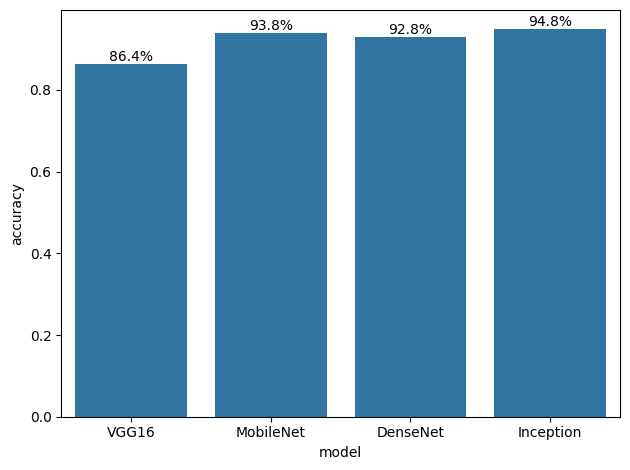

In [22]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()

plt.show()

In [23]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(model_DenseNet.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [25]:
for layer in model_MobileNet.layers:
    print("Layer Name:", layer.name)
    print("Layer Type:", type(layer).__name__)
    if hasattr(layer, 'input_shape'):
        print("Input Shape:", layer.input_shape)
    if hasattr(layer, 'output_shape'):
        print("Output Shape:", layer.output_shape)
    print("Trainable:", layer.trainable)
    print("===================")


Layer Name: mobilenetv2_1.00_224
Layer Type: Functional
Input Shape: (None, 299, 299, 3)
Output Shape: (None, 10, 10, 1280)
Trainable: True
Layer Name: global_average_pooling2d_3
Layer Type: GlobalAveragePooling2D
Trainable: True
Layer Name: dense_9
Layer Type: Dense
Trainable: True
Layer Name: dropout_6
Layer Type: Dropout
Trainable: True
Layer Name: dense_10
Layer Type: Dense
Trainable: True
Layer Name: dropout_7
Layer Type: Dropout
Trainable: True
Layer Name: dense_11
Layer Type: Dense
Trainable: True


In [27]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_DenseNet, val_accuracy_finetune_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
print(f'Validation Loss: {val_loss_finetune_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_DenseNet:.4f}')

====== Model Validation ======


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9142 - loss: 0.1974
Validation Loss: 0.1844
Validation Accuracy: 0.9284


In [28]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
DenseNet_test_preds = model_DenseNet.predict(test_generator)
DenseNet_test_pred_classes = np.argmax(DenseNet_test_preds, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step


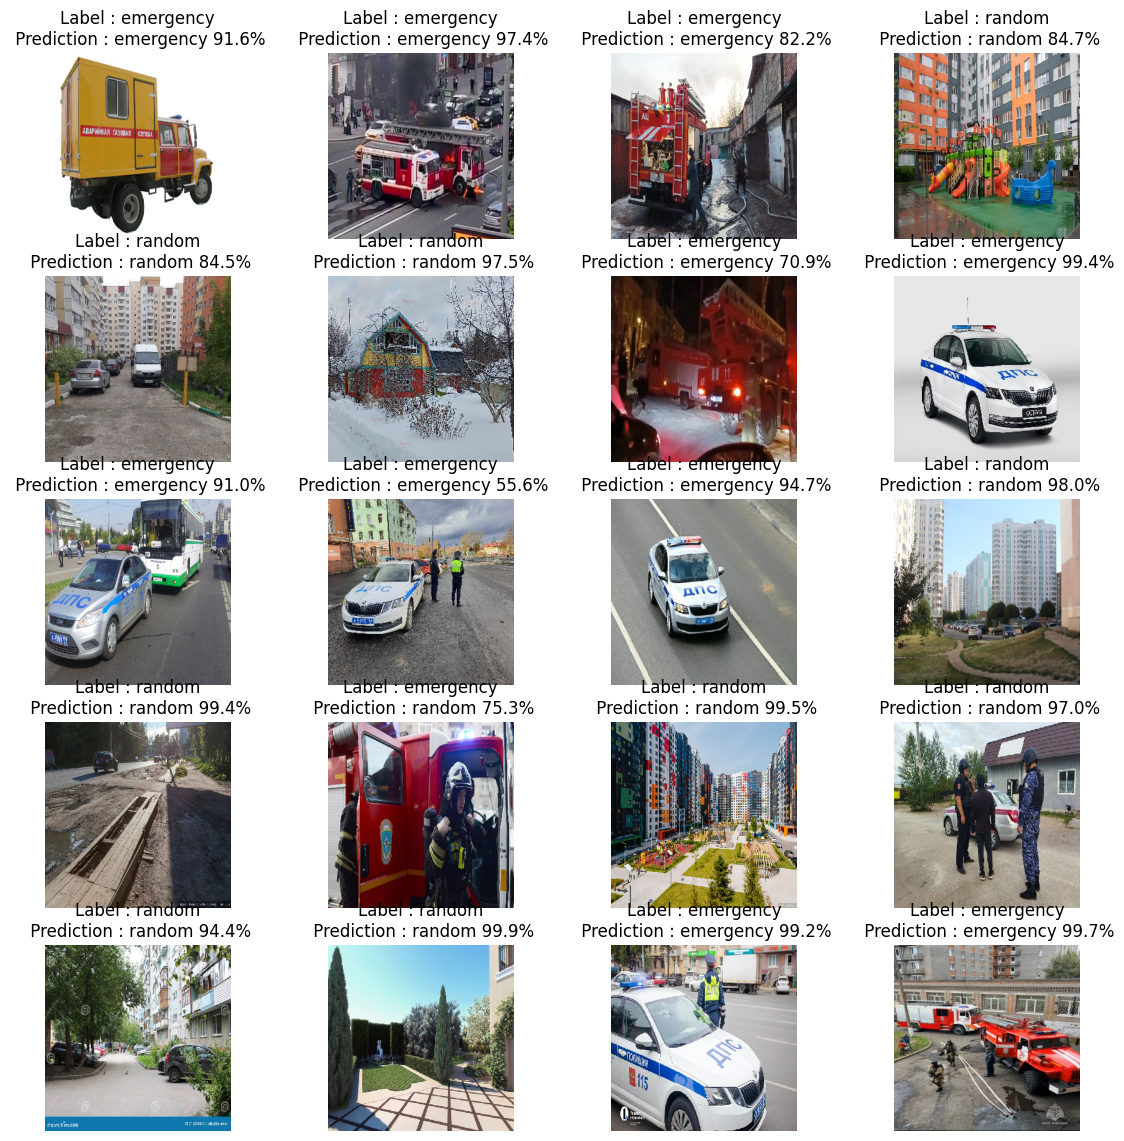

In [29]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_DenseNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

In [30]:
test_dir = r"dataset_main\test"

# Image dimensions
image_height = 299
image_width = 299

# Create ImageDataGenerator for test data
test_data_generator = ImageDataGenerator(rescale=1./255)

# Load test data using the generator
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=1,
    shuffle=False,  # Important: Set shuffle to False to maintain order
    class_mode='categorical'
)

# Get predictions and true labels
y_pred = model_DenseNet.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
file_names = test_generator.filenames

# Identify mispredicted indices
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Print file names of mispredicted images
print("\nMispredicted File Names:")
for idx in misclassified_indices:
    print(file_names[idx])

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Classification Report
class_names = list(test_generator.class_indices.keys())
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)

# Display Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Display Classification Report
print("\nClassification Report:")
print(class_report)

Found 405 images belonging to 2 classes.
  1/405 ━━━━━━━━━━━━━━━━━━━━ 1:46 263ms/step

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


405/405 ━━━━━━━━━━━━━━━━━━━━ 48s 118ms/step

Mispredicted File Names:
emergency\0000.jpg
emergency\00000.jpg
emergency\00051.jpg
emergency\00060.jpg
emergency\00064.png
emergency\00079.jpg
emergency\00085.jpg
emergency\00094.jpg
emergency\00099.jpg
emergency\00100.jpg
emergency\0052.jpg
emergency\0061.jpg
emergency\0065.png
emergency\0072.jpg
emergency\0082.jpg
emergency\0088.jpg
emergency\0097.jpg
emergency\0102.jpg
emergency\0103.jpg
random\0011.jpg
random\0019.jpg
random\0023.jpg
random\0025.jpg
random\0027.jpg
random\006.jpg
random\011.jpg
random\015.jpg
random\017.jpg
random\019.jpg
Confusion Matrix:
[[186  19]
 [ 10 190]]

Classification Report:
              precision    recall  f1-score   support

   emergency       0.95      0.91      0.93       205
      random       0.91      0.95      0.93       200

    accuracy                           0.93       405
   macro avg       0.93      0.93      0.93       405
weighted avg       0.93      0.93      0.93       405



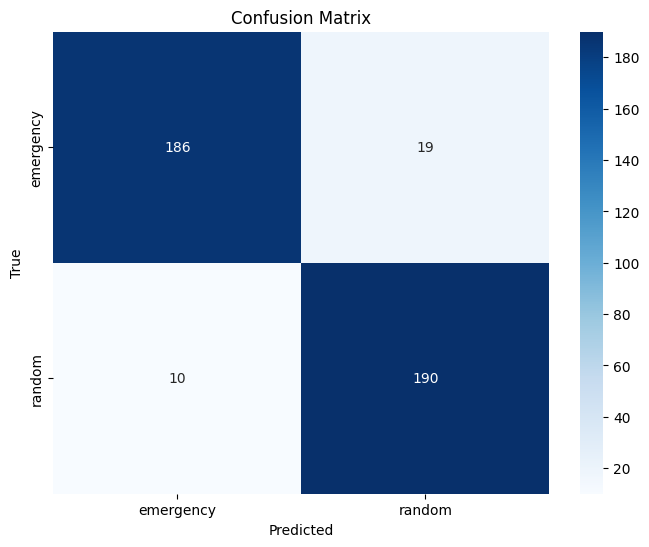

Classification Report:
              precision    recall  f1-score   support

   emergency       0.95      0.91      0.93       205
      random       0.91      0.95      0.93       200

    accuracy                           0.93       405
   macro avg       0.93      0.93      0.93       405
weighted avg       0.93      0.93      0.93       405



In [31]:
# Visualization of Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print Classification Report
print('Classification Report:')
print(class_report)